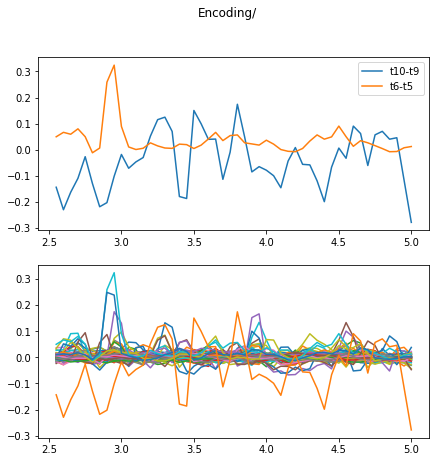

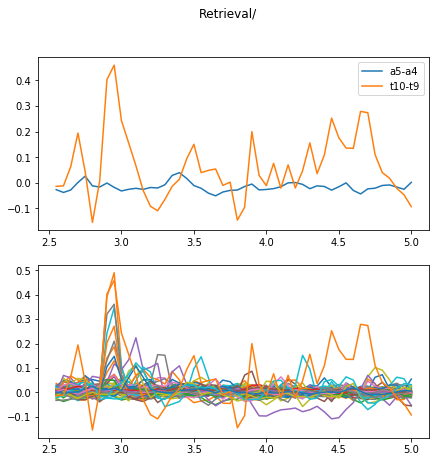

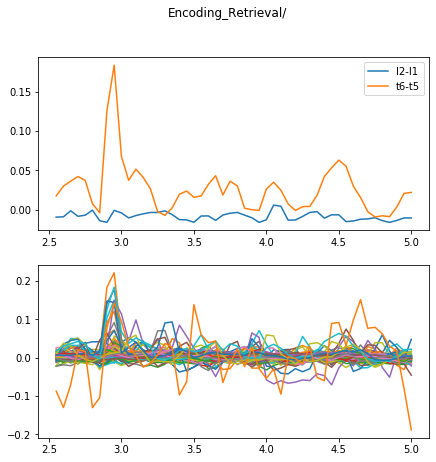

In [36]:
reps = ['Encoding/', 'Retrieval/', 'Encoding_Retrieval/']
path = '/media/karim/Datas4To/1_Analyses_Intra_EM_Odor/Ripples/feature/'

for rep in reps:
    mat = np.load(path+rep+'FERJ_all_odors_bipo_clean_feat_Zscore.npz')
    channels, data = mat['channel'], np.mean(mat['xpow'][0,:,50:100,:],axis=-1)
    time = mat['time'][50:100]
    idx_min = np.argmin(np.mean(data,axis=-1))
    idx_max = np.argmax(np.mean(data,axis=-1))
    fig = plt.figure(1,figsize=(7,7))
    fig.suptitle(rep)
    
    plt.subplot(211)
    plt.plot(time,data[[idx_min,idx_max],...].swapaxes(0,1))
    plt.legend(channels[[idx_min,idx_max]])
    plt.subplot(212)
    plt.plot(time,data.swapaxes(0,1))
    plt.show()

In [6]:
from brainpipe.statistics import perm_pvalue2level

def compute_th_by_su():
    th_by_su = []
    for su in sorted(subjects):
        th_su = []
        for freq in freqs:
            mat = np.load(f_form.format('All_subjects',freq,
                                        conds[0],conds[1]),allow_pickle=True)
            id_su = np.where(mat['su_codes']==su)[0]
            s_perm = mat['s_perm'][id_su].swapaxes(0,-1)
            th_perm = perm_pvalue2level(s_perm, p=th, maxst=True)[0]
            th_su.append(th_perm)
        th_by_su.append(np.max(th_su))
    return th_by_su

In [15]:
"""
Save mask for significant results + sum up results
"""
from collections import Counter
import numpy as np
import pandas as pd
from os.path import join, exists
from os import makedirs
from brainpipe.system import study

st = study('Olfacto')
exp = 'R'
path_npz = join(st.path, 'classified/0_clf_pow_sklearn_time_'+exp+'_by_resp/figure/')
path_to_save = join(path_npz, 'HG_results_th={}_minwin={}/{}/')
f_form = '{}_sources_{}_{}_{}_physFT.npz'
f_form = join(path_npz, f_form)
csv_form = 'results_df_roi={}_sign={}_th={}_minwin={}.csv'
save_csv = join(path_to_save, csv_form)

th = 0.05
method, subjects = 'power', ['CHAF','FERJ','LEFC','PIRJ','SEMC','VACJ']
freqs, conds = ['high_gamma'], ['low','high']
min_win = 3

# Create masks for a specific perm threshold
for f,freq in enumerate(freqs):
    mat = np.load(f_form.format('All_subjects',freq,conds[0],conds[1]),allow_pickle=True)
    th_by_su = compute_th_by_su()
    mask_f, labels, channels = np.array([]),[], []
    subj, power0, power1 = [], np.array([]), np.array([])
    num_elecs, time_vec = [], []
    da_mean, da_max, th_subjects = [], [], []
    for i,su in enumerate(sorted(subjects)):
        id_su = np.where(mat['su_codes']==su)
        s_labels = mat['s_labels'][id_su]
        s_channels = mat['s_channels'][id_su]
        #print('before select ROIs',mat['s_da'].shape, np.size(mat['s_da'][1]))
        if np.size(mat['s_da'][1]) > 1 :
            s_da = mat['s_da'][id_su]
        else:
            s_da = mat['s_da'][id_su][:,np.newaxis]
        if method == 'power':
            pow0, pow1 = mat['s_elec_pow0'][id_su], mat['s_elec_pow1'][id_su]
        elif method == 'rsa':
            pow0, pow1 = mat['rsa0'][id_su], mat['rsa1'][id_su]
        n_elecs, npts = s_da.shape
        
        
        for elec in range(n_elecs):
            da_elec = s_da[elec]
            
            pvals = np.array([1 if da_elec[t] > th_by_su[i] else 0 for t in range(npts)])
            time = np.arange(-1025,2025,50)
            
            underp = np.where(pvals == 1)[0]
            pvsplit = np.split(underp, np.where(np.diff(underp) != 1)[0]+1)
            signif = [k for k in pvsplit if len(k) >= min_win]

            if len(signif) >= 1:
                idx_ = np.concatenate(signif)
                labels.append(s_labels[elec])
                th_subjects.append(th_by_su[i])
                channels.append(s_channels[elec])
                subj.append(su)
                pow0_, pow1_= np.mean(pow0[elec,idx_]), np.mean(pow1[elec,idx_])
                
                time_vec.append(time[idx_][0])
                da_mean.append(np.mean(da_elec[idx_]))
                da_max.append(np.max(da_elec[idx_]))
                num_elecs.append(elec)
                power0 = np.vstack((power0,np.round(pow0_,2))) if np.size(power0) \
                                                        else np.round(pow0_,2)
                power1 = np.vstack((power1,np.round(pow1_,2))) if np.size(power1) \
                                                        else np.round(pow1_,2)
    
    #SUM UP results
    subj, th_subjects = np.array(subj)[np.newaxis], np.array(th_subjects)[np.newaxis]
    labels, channels = np.array(labels)[np.newaxis], np.array(channels)[np.newaxis]
    num_elecs, time_vec = np.array(num_elecs)[np.newaxis], np.array(time_vec)[np.newaxis]
    da_mean, da_max = np.array(da_mean)[np.newaxis], np.array(da_max)[np.newaxis]
    x_val = np.ones(labels.shape)
    power0, power1 = power0.swapaxes(0,1), power1.swapaxes(0,1)
    data = np.concatenate((subj,labels,channels,num_elecs,da_mean,da_max,th_subjects,
                           power0, power1, time_vec, x_val),axis=0)
    df = pd.DataFrame(data.T, columns=['subjects','labels','channels','num_elecs','da_mean',
                                       'da_max','th_su','pow0','pow1','time','counter'])
    print(freq, 'nb of sig elecs', df.shape[0])
    sig_rois = np.unique(labels)
    print(df)
    
    olf_rois = ['pPirT','OFC_olf','Amg']
    for roi in sig_rois:
        df_roi_f = df.loc[df['labels'] == roi]
        df_roi_f['pow0'] = df_roi_f['pow0'].astype(float)
        df_roi_f['pow1'] = df_roi_f['pow1'].astype(float)
        df_roi_f['sign'] = np.sign(df_roi_f['pow1'] - df_roi_f['pow0'])
        inc = (df_roi_f.loc[df_roi_f.sign == 1.0]).shape[0]
        dec = (df_roi_f.loc[df_roi_f.sign == -1.0]).shape[0]
        
        df_inc = df_roi_f.loc[df_roi_f.sign == 1.0].groupby(['subjects']).count()
        df_dec = df_roi_f.loc[df_roi_f.sign == -1.0].groupby(['subjects']).count()
        
        if (df_inc.shape[0] >= 3) or (df_inc.shape[0] >=2 and roi in olf_rois):
            if not exists(path_to_save.format(str(th),str(min_win),roi)):
                makedirs(path_to_save.format(str(th),str(min_win),roi))
            print(roi,'%s electrodes showed increased TPSim, while %s showed decrease out of %s elecs' 
                  % (inc,dec,inc+dec))
            df_plot = df_roi_f[['subjects','labels','channels','num_elecs','da_max','th_su',
                                'sign','time']].loc[df_roi_f.sign == 1.0]
            df_plot.to_csv(save_csv.format(str(th),str(min_win),roi,roi,'inc',str(th),str(min_win)))
            
        if (df_dec.shape[0] >= 3) or (df_dec.shape[0] >=2 and roi in olf_rois):
            if not exists(path_to_save.format(str(th),str(min_win),roi)):
                makedirs(path_to_save.format(str(th),str(min_win),roi))
            print(roi,'%s electrodes showed increased TPSim, while %s showed decrease out of %s elecs' 
                  % (inc,dec,inc+dec))
            df_plot = df_roi_f[['subjects','labels','channels','num_elecs','da_max','th_su',
                                'sign','time']].loc[df_roi_f.sign == -1.0]
            df_plot.to_csv(save_csv.format(str(th),str(min_win),roi,roi,'dec',str(th),str(min_win)))
        

-> Olfacto loaded
high_gamma nb of sig elecs 19
   subjects   labels   channels num_elecs             da_mean  \
0      CHAF      SFG    c'2-c'1         0  0.9555555555555554   
1      CHAF      SFG    f'6-f'5        29  0.9166666666666666   
2      CHAF      MFG   g'10-g'9        38  0.9444444444444444   
3      CHAF      MFG  g'11-g'10        39  0.9666666666666666   
4      CHAF      MFG    h'7-h'6        43  0.9624999999999999   
5      CHAF      MFG    h'8-h'7        44  0.9222222222222222   
6      CHAF      MFG    h'9-h'8        45  0.9111111111111111   
7      LEFC      ACC      k3-k2        12  0.9416666666666667   
8      LEFC  OFC_olf      o4-o3        21  0.9333333333333333   
9      LEFC  OFC_olf      o5-o4        22  0.9166666666666666   
10     LEFC      IFG      o9-o8        26                 1.0   
11     LEFC      SFG      s3-s2        30  0.9361111111111112   
12     PIRJ      PHG      d3-d2        14              0.8625   
13     PIRJ      PHG      d4-d3        15 

In [12]:
"""
PLOT significant data automatically
"""
import matplotlib.pyplot as plt
from itertools import product
from os import listdir
from brainpipe.visual import BorderPlot, addLines, rmaxis
from matplotlib.ticker import MaxNLocator, ScalarFormatter

st = study('Olfacto')
exp = 'R'
path_rep = join(st.path, 'classified/0_clf_pow_sklearn_time_'+exp+'_by_cond/figure/')
path_res = join(path_npz, 'HG_results_th={}_minwin={}/')
mat_file = join(path_rep, 'All_subjects_sources_{}_{}_{}_physFT.npz')
plt_save = 'Pow_DA_roi={}_su={}_ch={}_th={}_minwin={}.png'

ths, min_wins = ['0.05'], ['3','4','5']
freq, conds = 'gamma_high', ['low','high']
to_plot = [8,30]

for th, win in product(ths,min_wins):
    rois = listdir(path_res.format(th,win))
    for roi in rois:
        csv_file = [f for f in listdir(path_res.format(th,win)+roi+'/') if f.endswith('.csv')]
        df_res = pd.read_csv(path_res.format(th,win)+roi+'/'+csv_file[0])
        mat = np.load(mat_file.format(freq, conds[0], conds[1]))

        for su,ch in zip(df_res['subjects'],df_res['channels']):
            print(roi,su,ch,'th=',th,'win=',win)
            idx_ = [i for i,chan in enumerate(mat['s_channels']) \
                    if (chan == ch) & (mat['su_codes'][i] == su)]
            data_pow = np.concatenate((mat['s_elec_pow0'][idx_][:,to_plot[0]:to_plot[1]],
                                       mat['s_elec_pow1'][idx_][:,to_plot[0]:to_plot[1]]), axis=0)
            print(idx_, data_pow.shape)
            auc = mat['s_da'][idx_][:,to_plot[0]:to_plot[1]]
            th_su = df_res['th_su'].loc[((df_res.subjects == su) & (df_res.channels == ch))]
            th_su = float(th_su)

            xfmt = ScalarFormatter(useMathText=True)
            xfmt.set_powerlimits((0,3))
            fig = plt.figure(1,figsize=(7,7))
            title = 'HG Power & DA for '+roi+' ('+su+' in '+str(ch)+')'
            fig.suptitle(title, fontsize=12)
                
            plt.subplot(211)
            time = mat['s_time'][to_plot[0]:to_plot[1]] - 3 
            BorderPlot(time, data_pow, y=[0,1], color=['blue','red'],linewidth=2, 
                          ncol=1, xlabel='Time (s)',ylabel = r'Power', legend=conds)
            rmaxis(plt.gca(), ['right', 'top'])
            addLines(plt.gca(), vLines=[0], vColor=['darkgray'], vWidth=[2])
            plt.legend(loc=0, handletextpad=0.1, frameon=False)
            plt.gca().yaxis.set_major_locator(MaxNLocator(3,integer=True))
            
            #Plot significant time period on power data
            points_sig = [t for idx_t, t in enumerate(time) if auc[0,idx_t]>th_su]
            if len(points_sig) > 1:
                h = plt.axvspan(points_sig[0], points_sig[-1],
                        color='r', alpha=0.3)

            plt.subplot(212)
            BorderPlot(time, auc, color='black',xlabel='Time (s)', ylim=[0.2,0.9], 
                           ylabel='Decoding accuracy (%)',linewidth=2, alpha=0.3)
            rmaxis(plt.gca(), ['right', 'top'])
            addLines(plt.gca(), vLines=[0], vColor=['darkgray'], vWidth=[2])
            plt.gca().yaxis.set_major_locator(MaxNLocator(3,integer=True))
            plt.plot(time, [th_su]*np.ones(len(time)), '--', color='r', linewidth=2)
            plt.savefig(path_res.format(th,win)+roi+'/'+plt_save.format(roi,su,ch,th,win))
            plt.clf()
            plt.close()

-> Olfacto loaded
aHC FERJ b'4-b'3 th= 0.05 win= 3
[9] (2, 22)
aHC PIRJ b2-b1 th= 0.05 win= 3
[110] (2, 22)
aHC PIRJ b3-b2 th= 0.05 win= 3
[111] (2, 22)
aHC PIRJ b4-b3 th= 0.05 win= 3
[112] (2, 22)
aHC SEMC b3-b2 th= 0.05 win= 3
[58] (2, 22)
aHC VACJ b'4-b'3 th= 0.05 win= 3
[133] (2, 22)
IFG LEFC o9-o8 th= 0.05 win= 3
[52] (2, 22)
IFG SEMC j3-j2 th= 0.05 win= 3
[72] (2, 22)
IFG SEMC u10-u9 th= 0.05 win= 3
[89] (2, 22)
IFG VACJ o10-o9 th= 0.05 win= 3
[159] (2, 22)
IFG VACJ o'11-o'10 th= 0.05 win= 3
[165] (2, 22)
IFG VACJ o'12-o'11 th= 0.05 win= 3
[166] (2, 22)
OFC_olf CHAF i'2-i'1 th= 0.05 win= 3
[212] (2, 22)
OFC_olf LEFC o5-o4 th= 0.05 win= 3
[49] (2, 22)
OFC_olf VACJ o'8-o'7 th= 0.05 win= 3
[164] (2, 22)
SFG CHAF e'3-e'2 th= 0.05 win= 3
[180] (2, 22)
SFG CHAF e'4-e'3 th= 0.05 win= 3
[181] (2, 22)
SFG LEFC k2-k1 th= 0.05 win= 3
[39] (2, 22)
SFG LEFC s2-s1 th= 0.05 win= 3
[55] (2, 22)
SFG LEFC s3-s2 th= 0.05 win= 3
[56] (2, 22)
SFG SEMC y6-y5 th= 0.05 win= 3
[101] (2, 22)
aHC FERJ b'4-